In [1]:
import sys
sys.path.insert(1, r"C:\\Users\\micha\\Documents\\Imperial Courses\\Thesis\\IAEA-thesis")
from Stage1.GAT.GATModel import GraphAttentionNetwork
from Single_Website_Download.Download import main
import torch
from Stage1.ExtractingGraphs.HTMLtoGraph import html_to_graph, EdgeFeatures
from Stage1.ExtractingGraphs.seleniumDriver import *
from Stage1.ExtractingLabels.swde_label_extraction import *
from Stage2.txtGraphs.textExtractor import extract_chunk_xpaths
from Stage2.txtGraphs.extract_mini_txt_graphs_helper import main as txtExtractor
from Stage1.tree_helpers import *
from pathlib import Path
from scipy import sparse
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
#Import model
model = GraphAttentionNetwork(in_dim = 114, edge_in_dim = 200, edge_emb_dim = 32, hidden1 = 32, hidden2 = 32, hidden3 = 8, heads = 2)
state_dict = torch.load("../../Stage1/GAT/FULLTRAINEDALLDATAModelf1-75-learning.pt", map_location=torch.device(device))
model.load_state_dict(state_dict)
model.to(device)

GraphAttentionNetwork(
  (tr1): TransformerConv(114, 32, heads=2)
  (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (tr2): TransformerConv(64, 32, heads=1)
  (ln2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (tr3): TransformerConv(32, 8, heads=1)
  (edge_mlp): Sequential(
    (0): Linear(in_features=48, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [10]:
url = ""
htmlFile = "C:\\Users\\micha\\Documents\\Imperial Courses\\Thesis\\IAEA-thesis\\data\\swde\\sourceCode\\sourceCode\\movie\\movie\\movie-allmovie(2000)\\0000.htm"
# url = r"https://www.nucnet.org/news/parliament-resolution-paves-way-for-establishing-nuclear-energy-legislation-6-4-2024"
# htmlFile = Path("C:/Users/micha/Documents/Imperial Courses/Thesis/IAEA-thesis/data/websites/test.html")
# main(url,1,htmlFile)

In [11]:
sorted_label_index, xpaths, txts = txtExtractor(htmlFile, model, safeurl=url) #remove all a's that are diff domain to safeurl
print(sorted_label_index[:10])
print(xpaths[:10])
print(txts[:10])

[[280 279]
 [560 559]
 [561 559]
 [301 302]
 [387 386]
 [560 561]
 [402 403]
 [559 562]
 [560 562]
 [559 563]]
[['/html/body/div/div[3]/table/tbody/tr/td[1]/table/tbody/tr[2]/td/table/tbody/tr/td[2]/div/table[3]/tbody/tr[2]/td[2]', '/html/body/div/div[3]/table/tbody/tr/td[1]/table/tbody/tr[2]/td/table/tbody/tr/td[2]/div/table[3]/tbody/tr[2]/td[1]'], ['/html/body/div/div[3]/table/tbody/tr/td[1]/table/tbody/tr[2]/td/table/tbody/tr/td[1]/table[2]/tbody/tr[11]/td/table/tbody/tr[3]/td/div/ul/li[2]', '/html/body/div/div[3]/table/tbody/tr/td[1]/table/tbody/tr[2]/td/table/tbody/tr/td[1]/table[2]/tbody/tr[11]/td/table/tbody/tr[3]/td/div/ul/li[1]'], ['/html/body/div/div[3]/table/tbody/tr/td[1]/table/tbody/tr[2]/td/table/tbody/tr/td[1]/table[2]/tbody/tr[11]/td/table/tbody/tr[3]/td/div/ul/li[3]', '/html/body/div/div[3]/table/tbody/tr/td[1]/table/tbody/tr[2]/td/table/tbody/tr/td[1]/table[2]/tbody/tr[11]/td/table/tbody/tr[3]/td/div/ul/li[1]'], ['/html/body/div/div[3]/table/tbody/tr/td[1]/table/tbody

In [12]:
groundTruthFP = htmlFile.replace("\\swde\\sourceCode\\sourceCode", "\\swde_HTMLgraphsOLD").replace(".htm", "\\label_index.npy")
groundT = np.load(groundTruthFP)

In [6]:
def top_k_hits(predictions: np.ndarray,
               ground_truth: np.ndarray,
               k: int) -> np.ndarray:
    p = np.asarray(predictions)
    g = np.asarray(ground_truth)
    if p.ndim != 2 or p.shape[1] != 2 or g.ndim != 2 or g.shape[1] != 2: raise ValueError("predictions and ground_truth must be 2D arrays of shape (N, 2).")

    # --- Build adjacency: node -> list of prediction row indices (in rank order) ---
    # O(P) pass; avoids O(P * |V|) masking.
    adj = defaultdict(list)
    for idx, (u, v) in enumerate(p):
        adj[u].append(idx)
        adj[v].append(idx)

    # Only care about nodes that appear in ground truth
    nodes_gt = np.unique(g)

    # Mark predicted rows that are within top-k for any relevant node
    selected_rows = np.zeros(len(p), dtype=bool)
    for u in nodes_gt:
        rows = adj.get(u)
        if rows:
            # rows already in rank order; take first k
            selected_rows[rows[:k]] = True

    # --- Match (undirected) ground-truth edges against selected predicted edges ---
    # Canonicalize by sorting each pair.
    p_sel_sorted = np.sort(p[selected_rows], axis=1)
    gTuple = [tuple(entry) for entry in g]

    gMask = np.array([False]*len(g))
    for entry in p_sel_sorted:
        if tuple(entry) in gTuple:
            gMask[gTuple.index(tuple(entry))] = True

    return g[gMask], g[~gMask]

hits, misses = top_k_hits(sorted_label_index, groundT, 5)
print(len(hits), len(misses))
mask = np.array([entry in hits for entry in sorted_label_index])
txts = np.array(txts)
print(txts[mask])


74 1738
[['Is related to:'
  'The War Zone\xa0 \n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t(1999, Tim Roth)']
 ['accident' 'addict']
 ['accident' 'drugs']
 ...
 ['» In the Spotlight' 'Meditative']
 ['» In the Spotlight' 'Fathers and Daughters']
 ['» In the Spotlight' 'Brief Nudity']]


In [14]:
jsonContent = load_json_of_swde_file(htmlFile, "../..")
htmlFilepth = Path(htmlFile)
txtPairs = list(iterate_pairs(jsonContent, htmlFilepth.name))
print(len(txtPairs))

def top_k_hits_txt(txtPairs, candidateTxtpairs, k, dualDirection=True):
    """
    Checks if key, value edge in txtPairs appears in the top k (w.r.t key) of candidateTxtPairs"""
    found = []
    for gttxt1, gttxt2 in txtPairs:
        gttxt1, gttxt2 = normalise_text(gttxt1), normalise_text(gttxt2)

        # This checks if gttxt1 - gttxt2 is in gttxt1's top k
        i = 0
        for candidatetxt1, candidatetxt2 in candidateTxtpairs:
            if i >= k:
                break

            candidatetxt1, candidatetxt2 = normalise_text(candidatetxt1), normalise_text(candidatetxt2)
            if gttxt1 in candidatetxt1 or gttxt1 in candidatetxt2:
                i += 1
                if gttxt1 in candidatetxt1 and gttxt2 in candidatetxt2:
                    found.append([[gttxt1, gttxt2], i])
                    break
                elif gttxt2 in candidatetxt1 and gttxt1 in candidatetxt2:
                    found.append([[gttxt1, gttxt2], i])
                    break
        
        if dualDirection:
            # This checks if gttxt1 - gttxt2 is in gttxt2's top k
            j=0
            for candidatetxt1, candidatetxt2 in candidateTxtpairs:
                if j >= k:
                    break

                candidatetxt1, candidatetxt2 = normalise_text(candidatetxt1), normalise_text(candidatetxt2)
                if gttxt2 in candidatetxt1 or gttxt2 in candidatetxt2:
                    j += 1
                    if gttxt1 in candidatetxt1 and gttxt2 in candidatetxt2:
                        found.append([[gttxt2, gttxt1], j])
                        break
                    elif gttxt2 in candidatetxt1 and gttxt1 in candidatetxt2:
                        found.append([[gttxt2, gttxt1], j])
                        break

    return found

hitstxt = top_k_hits_txt(txtPairs, txts, 1, False)
print(len(hitstxt))
hitstxt


61
17


[[['amgworkid', 'v155010'], 1],
 [['attributes', 'highproductionvalues'], 1],
 [['cinematicprocess', 'panavision'], 1],
 [['director', 'atomegoyan'], 1],
 [['flags', 'sexualsituations'], 1],
 [['genres', 'drama'], 1],
 [['keywords', 'addict'], 1],
 [['mpaarating', 'r'], 1],
 [['mpaareasons', 'forsexualityandsomelanguage'], 1],
 [['moods', 'inaminorkey'], 1],
 [['otherrelatedworks', 'isrelatedto'], 1],
 [['isrelatedto', 'thewarzone'], 1],
 [['producedby', 'allianceatlantiscommunications'], 1],
 [['setin', 'britishcolumbiacanada'], 1],
 [['themes', 'fathersanddaughters'], 1],
 [['tones', 'bleak'], 1],
 [['types', 'psychologicaldrama'], 1]]

1
3
2
3
3
3
4
3
5
3
10
3


C:\Users\micha\AppData\Local\Temp\ipykernel_92248\4015497192.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(distributions, labels=[str(k) for k in ks], showmeans=True)


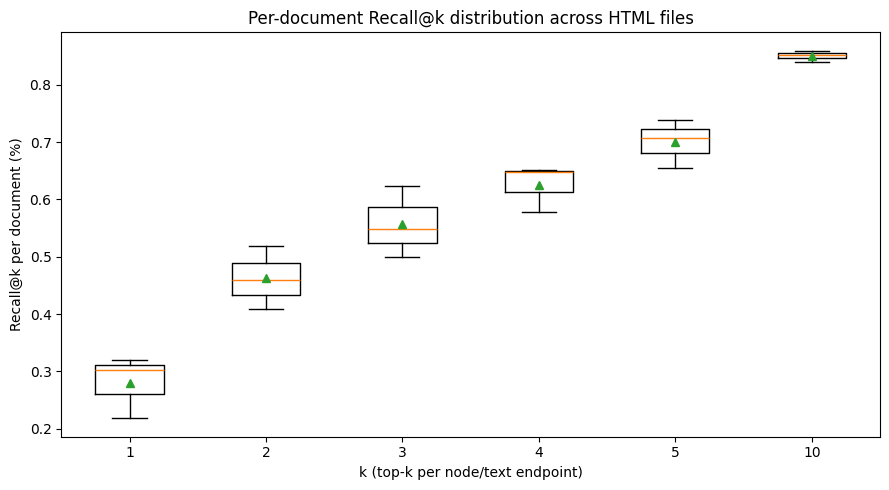

In [ ]:
SRC_FOLDER1 = Path("../../data/swde/sourceCode/sourceCode/movie/movie/movie-allmovie(2000)")

ks = [1,2,3,4,5,10]
distributions = []
for k in ks:
    print(k)
    percentageFound = []
    html_files = list(SRC_FOLDER1.rglob("*.htm"))
    jsonContent = load_json_of_swde_file(htmlFile.__str__(), "../..")
    
    for htmlFile in html_files:
        _,_,txts = txtExtractor(htmlFile, model, alreadyConvertedToGraph=htmlFile.__str__().replace("\\swde\\sourceCode\\sourceCode", "\\swde_HTMLgraphsOLD").replace(".htm", ""))
        txtPairs = list(iterate_pairs(jsonContent, htmlFile.name))
        hitstxt = top_k_hits_txt(txtPairs, txts, k)

        percentageFound.append(len(hitstxt)/(2*len(txtPairs)))

        if len(percentageFound) % 200 == 0:
            print(len(percentageFound))

    distributions.append(percentageFound)

plt.figure(figsize=(9, 5))
plt.boxplot(distributions, labels=[str(k) for k in ks], showmeans=True)
plt.xlabel("k (top-k per node/text endpoint)")
plt.ylabel("Recall@k per document (%)")
plt.title("Per-document Recall@k distribution across HTML files")
plt.tight_layout()
plt.show()

1) see how many external links I am picking up, if its an acceptable amount, dw about it
filter out links in html that point to external webpages

2) compare this to just putting it all into an llm. make this a prompting model